In [1]:
# NLP では以下ステップを行う
# 1.文章を単語に分割
# 2.単語を辞書化
# 3.埋め込み・・・小さなベクトルで個々の単語を表現する




# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf
import numpy as np

In [3]:
# 外部にあるテキストファイルを取得する
from six.moves import urllib

import errno
import os
import zipfile

In [4]:
WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [5]:
words = fetch_words_data()

In [6]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [7]:
# 辞書作成

from collections import Counter

# 単語の埋め込みをお行う。この場合は5万語登録可能な辞書を用意するイメージ。つまり全単語が5万語に集約される
vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary]) # 出てきた単語をnumpy配列にしているだけ
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [9]:
# 未知の単語を'UHK'として、既知の単語を登場回数順で並べている
[("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)

[('UNK', None),
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510),
 ('four', 108182),
 ('six', 102145),
 ('seven', 99683),
 ('with', 95603),
 ('on', 91250),
 ('are', 76527),
 ('it', 73334),
 ('from', 72871),
 ('or', 68945),
 ('his', 62603),
 ('an', 61925),
 ('be', 61281),
 ('this', 58832),
 ('which', 54788),
 ('at', 54576),
 ('he', 53573),
 ('also', 44358),
 ('not', 44033),
 ('have', 39712),
 ('were', 39086),
 ('has', 37866),
 ('but', 35358),
 ('other', 32433),
 ('their', 31523),
 ('its', 29567),
 ('first', 28810),
 ('they', 28553),
 ('some', 28161),
 ('had', 28100),
 ('all', 26229),
 ('more', 26223),
 ('most', 25563),
 ('can', 25519),
 ('been', 25383),
 ('such', 24413),
 ('many', 24

In [12]:
dictionary
# 頻度順に並べた単語に　0～49999 までの番号を割り振って辞書化している

{'UNK': 0,
 'the': 1,
 'of': 2,
 'and': 3,
 'one': 4,
 'in': 5,
 'a': 6,
 'to': 7,
 'zero': 8,
 'nine': 9,
 'two': 10,
 'is': 11,
 'as': 12,
 'eight': 13,
 'for': 14,
 's': 15,
 'five': 16,
 'three': 17,
 'was': 18,
 'by': 19,
 'that': 20,
 'four': 21,
 'six': 22,
 'seven': 23,
 'with': 24,
 'on': 25,
 'are': 26,
 'it': 27,
 'from': 28,
 'or': 29,
 'his': 30,
 'an': 31,
 'be': 32,
 'this': 33,
 'which': 34,
 'at': 35,
 'he': 36,
 'also': 37,
 'not': 38,
 'have': 39,
 'were': 40,
 'has': 41,
 'but': 42,
 'other': 43,
 'their': 44,
 'its': 45,
 'first': 46,
 'they': 47,
 'some': 48,
 'had': 49,
 'all': 50,
 'more': 51,
 'most': 52,
 'can': 53,
 'been': 54,
 'such': 55,
 'many': 56,
 'who': 57,
 'new': 58,
 'used': 59,
 'there': 60,
 'after': 61,
 'when': 62,
 'into': 63,
 'american': 64,
 'time': 65,
 'these': 66,
 'only': 67,
 'see': 68,
 'may': 69,
 'than': 70,
 'world': 71,
 'i': 72,
 'b': 73,
 'would': 74,
 'd': 75,
 'no': 76,
 'however': 77,
 'between': 78,
 'about': 79,
 'over': 80

In [13]:
data
# 最初に作ったテキストファイルに上記で辞書化したenum値を設定していっている

array([5234, 3081,   12, ...,   22,   16,   73])

In [14]:
" ".join(words[:9]), data[:9]
# 例としてテキストファイルとenum値の結びつきを見てみる

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [15]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])
# 今度はenum値から英語への変換が出来ていることを確認

'cycles originated as a term of abuse first used'

In [22]:
# Generate batches 個々の処理は詳細不明
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [23]:
np.random.seed(42)
data_index = 0
batch, labels = generate_batch(8, 2, 1)


In [24]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195]),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [25]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]]),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

In [26]:
# Build the model
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# 最近傍をサンプリングするためにランダムな検証セットを選びます。
# ここでは、検証サンプルを、数値IDが低い単語に限定します。これは、構造上、最も頻繁に使用されるものです。
valid_size = 16     # 類似性を評価する単語のランダムな集合。
valid_window = 100  # 配布の先頭にある開発サンプルのみを選択.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # サンプリングする負の例の数

learning_rate = 0.01

In [27]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [28]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [29]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [30]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

In [31]:
# Train the model
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  289.90948486328125
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, egyptians, richards, legionnaires, opener, leonel,
Nearest to up: clair, drives, steadfas

In [32]:
np.save("./my_final_embeddings.npy", final_embeddings)

In [33]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

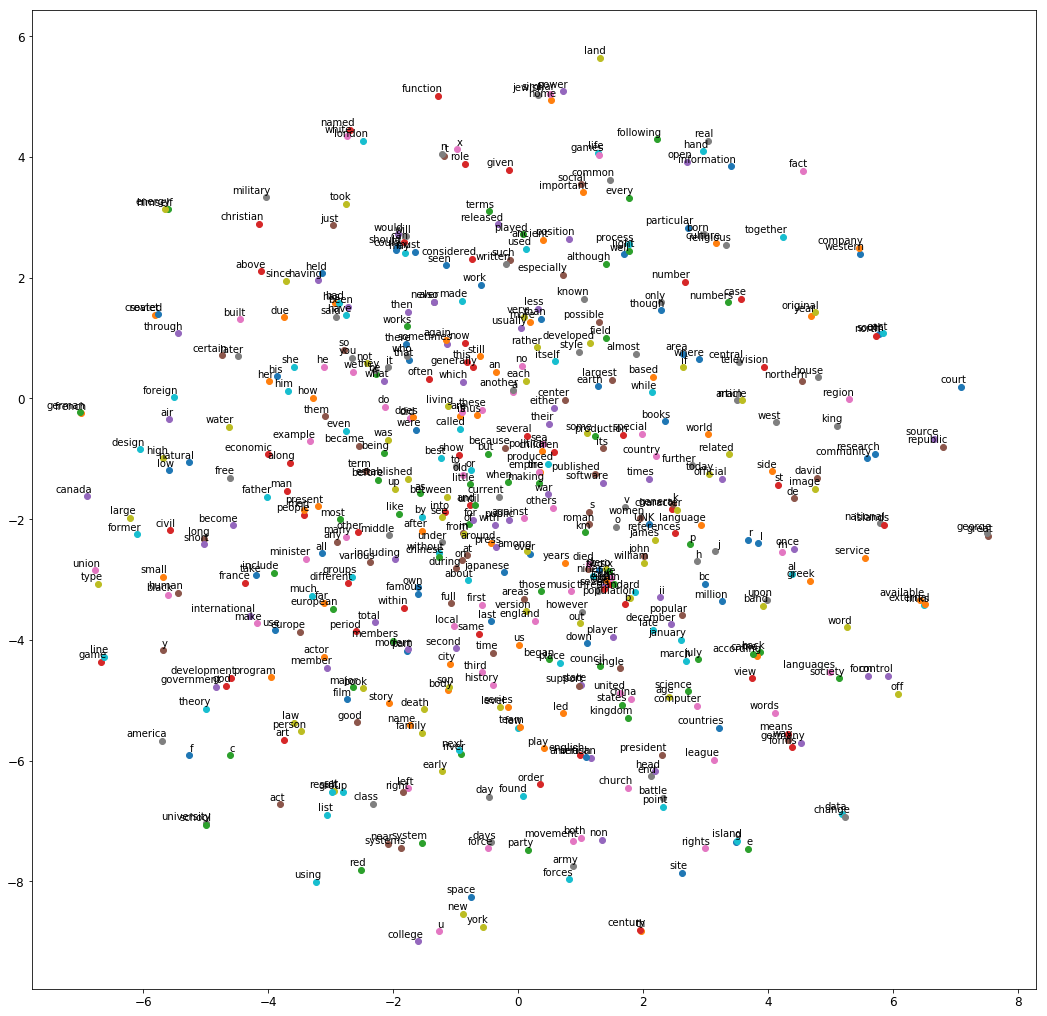

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)